In [4]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from point_e.diffusion.gaussian_diffusion import GaussianDiffusion
import numpy as np
import clip
from point_e.models.sepe import Sepe
from point_e.diffusion.configs import DIFFUSION_CONFIGS

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import json
import os
import glob


class ABODatasetSimplified(Dataset):
    """
    Further simplified PyTorch Dataset for loading ABO data.
    Focuses on core loading steps, assuming data is mostly well-formed.

    Args:
        data_root (str): Path to the root directory.
        n_ctx (int): Target number of points for the point cloud.
        clip_preprocessor (callable): Preprocessing function for CLIP images.
        image_subdir (str): Optional subdirectory for images.
        pc_keys (tuple): Keys for coordinates and colors in NPZ files.
    """
    def __init__(self, data_root, n_ctx, clip_preprocessor,image_subdir='', pc_keys=('coords', 'colors'), max_samples=None):
        super().__init__()
        self.data_root = data_root
        self.n_ctx = n_ctx
        self.image_subdir = image_subdir
        self.pc_keys = pc_keys
        self.clip_preprocess = clip_preprocessor

        self.captions_dir = os.path.join(data_root, 'captions')
        self.images_dir = os.path.join(data_root, 'images')
        self.pointclouds_dir = os.path.join(data_root, 'pointclouds')
        self.jsonl_path = os.path.join(data_root, 'final_dataset.jsonl')

        if not os.path.exists(self.jsonl_path):
            raise FileNotFoundError(f"Error: JSONL file not found at {self.jsonl_path}")

        self.uids = self._load_uids()
        
        if max_samples is not None:
            self.uids = self.uids[:max_samples]
        if not self.uids:
            raise ValueError(f"No UIDs loaded from {self.jsonl_path}.")
        print(f"Found {len(self.uids)} UIDs in jsonl file.")

    def _load_uids(self):
        """ Loads UIDs from the JSON Lines file. """
        uids = []
        with open(self.jsonl_path, 'r') as f:
            for line in f:
                try:
                    data = json.loads(line.strip())
                    uid = None
                    if isinstance(data, dict) and 'uid' in data:
                        uid = data['uid']
                    elif isinstance(data, str):
                         uid = data
                    if uid:
                        uids.append(uid)
                except json.JSONDecodeError:
                     pass # Silently ignore invalid JSON lines
        return uids

    def __len__(self):
        """ Returns the total number of samples. """
        return len(self.uids)

    def __getitem__(self, idx):
        """ Loads and returns a single data sample. Minimal error checking. """
        uid = self.uids[idx]
        caption = "" # Default empty caption
        image_to_return = torch.zeros((3, 224, 224)) # Default blank image tensor
        pointcloud_tensor = torch.zeros((6, self.n_ctx)) # Default blank point cloud tensor

        try:
            # --- Load Caption (optional) ---
            caption_path = os.path.join(self.captions_dir, f"{uid}.txt")
            if os.path.exists(caption_path):
                 with open(caption_path, 'r', encoding='utf-8') as f:
                    caption = f.read().strip()

            # --- Load Image ---
            image_base_path = os.path.join(self.images_dir, uid)
            if self.image_subdir:
                 image_base_path = os.path.join(image_base_path, self.image_subdir)

            image_path = None
            possible_image_paths = glob.glob(f"{image_base_path}.*")
            if not possible_image_paths:
                 possible_image_paths = glob.glob(os.path.join(image_base_path, '*.*'))

            img_extensions = ['.png', '.jpg', '.jpeg', '.webp']
            for path in possible_image_paths:
                if any(path.lower().endswith(ext) for ext in img_extensions):
                    image_path = path
                    break

            if image_path: # Only process if an image path was found
                image_to_return = Image.open(image_path).convert('RGB')
                image_to_return = self.clip_preprocess(image_to_return)
            # else: image_tensor remains zeros if no path found

            # --- Load Point Cloud ---
            pc_path = os.path.join(self.pointclouds_dir, f"{uid}.npz")
            if os.path.exists(pc_path): # Only process if npz file exists
                data = np.load(pc_path)
                coord_key = self.pc_keys[0]
                color_key = self.pc_keys[1]

                # Check if keys exist, proceed only if both are present
                if coord_key in data and color_key in data:
                    coords = data[coord_key]
                    colors = data[color_key]

                    # Basic check for non-empty arrays and correct second dimension
                    if coords.ndim == 2 and coords.shape[1] == 3 and \
                       colors.ndim == 2 and colors.shape[1] == 3 and \
                       coords.shape[0] == colors.shape[0] and coords.shape[0] > 0:

                        # Normalize colors if needed
                        if colors.max() > 1.0:
                            colors = colors / 255.0
                        centroid = np.mean(coords, axis=0)  # Compute centroid
                        coords_centered = coords - centroid  # Center the point cloud
                        max_dist = np.max(np.linalg.norm(coords_centered, axis=1))  # Max distance from origin
                        if max_dist > 0:  # Avoid division by zero
                            coords_normalized = coords_centered / max_dist  # Scale to [-1, 1]
                        else:
                            coords_normalized = coords_centered

                        #pointcloud = np.concatenate([coords.astype(np.float32),
                         #                            colors.astype(np.float32)], axis=1)
                        pointcloud = np.concatenate([coords_normalized.astype(np.float32), colors.astype(np.float32)], axis=1)
                        # Subsample or pad points
                        num_points = pointcloud.shape[0]
                        if num_points == self.n_ctx:
                            indices = np.arange(num_points)
                        elif num_points > self.n_ctx:
                            indices = np.random.choice(num_points, self.n_ctx, replace=False)
                        else: # num_points < n_ctx
                            indices = np.random.choice(num_points, self.n_ctx, replace=True)

                        sampled_points = pointcloud[indices, :]
                        pointcloud_tensor = torch.from_numpy(sampled_points).float().transpose(0, 1) # [6, n_ctx]
                    # else: pointcloud_tensor remains zeros if shapes/keys are invalid

            # else: pointcloud_tensor remains zeros if npz file not found

        except Exception as e:
            # Print error for the specific item but allow dataloader to continue
            # by returning the default zero tensors.
            # WARNING: This might lead to training on invalid data if errors are frequent.
            # Consider adding filtering logic or stricter error handling if needed.
            print(f"Warning: Error processing item for UID {uid}. Returning default tensors. Error: {e}")
            # traceback.print_exc() # Uncomment for full traceback during debugging


        # --- Return Sample ---
        # Always returns a dictionary, potentially with default zero tensors if errors occurred.
        return {
            'caption': caption,
            'image': image_to_return,
            'pointcloud': pointcloud_tensor
        }

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset parameters
DATASET_ROOT = '../data'
TARGET_POINTS = 1024
BATCH_SIZE = 16

# Load CLIP preprocessor
clip_model, clip_preprocess = clip.load("ViT-L/14", device="cpu", jit=False)

# Dataset and DataLoader
dataset = ABODatasetSimplified(
    data_root=DATASET_ROOT,
    n_ctx=TARGET_POINTS,
    clip_preprocessor=clip_preprocess,
    pc_keys=('coords', 'colors'),
    max_samples = None
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Diffusion setup
diffusion_steps = 1024
diffusion_config_name = 'base40M'
diffusion_kwargs = DIFFUSION_CONFIGS.get(diffusion_config_name, {})
#model_var_type = diffusion_kwargs.get('model_var_type', 'fixed_large')
model_var_type = diffusion_kwargs.get('model_var_type', 'learned_range')
model_mean_type = diffusion_kwargs.get('model_mean_type', 'epsilon')
loss_type = diffusion_kwargs.get('loss_type', 'mse')
beta_schedule_name = diffusion_kwargs.get('beta_schedule', 'linear')
print(f"Using diffusion parameters: var_type={model_var_type}, mean_type={model_mean_type}, loss_type={loss_type}, schedule={beta_schedule_name}")

# Define linear beta schedule manually
beta_start = 0.0001
beta_end = 0.02
betas = np.linspace(beta_start, beta_end, diffusion_steps)

init_args = {
    'betas': betas,
    'model_var_type': model_var_type,
    'model_mean_type': model_mean_type,
    'loss_type': loss_type,
}
diffusion = GaussianDiffusion(**init_args)
print(f"Using GaussianDiffusion with T={diffusion.num_timesteps}")

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

Found 7890 UIDs in jsonl file.
Using diffusion parameters: var_type=learned_range, mean_type=epsilon, loss_type=mse, schedule=linear
Using GaussianDiffusion with T=1024


In [7]:
#load:


checkpoint_path = os.path.join(checkpoint_dir, f'model_FixCA1_epoch_30.pt')
checkpoint = torch.load(checkpoint_path, map_location=device)
model = Sepe(device=device, use_cross_attention=True).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.train()

Sepe(
  (time_embed): MLP(
    (c_fc): Linear(in_features=512, out_features=2048, bias=True)
    (c_proj): Linear(in_features=2048, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
  )
  (ln_pre): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (backbone): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (c_qkv): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attention): QKVMultiheadAttention()
        )
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (ln_post): Laye

In [4]:

model = Sepe(device=device, use_cross_attention=False).to(device)
model.train()


Sepe(
  (time_embed): MLP(
    (c_fc): Linear(in_features=512, out_features=2048, bias=True)
    (c_proj): Linear(in_features=2048, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
  )
  (ln_pre): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (backbone): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (c_qkv): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attention): QKVMultiheadAttention()
        )
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (ln_post): Laye

In [8]:
def laplacian_smoothness_loss(points, k=5):
    # points: [B, N, 3]
    B, N, _ = points.shape
    distances = torch.cdist(points, points)  # [B, N, N]
    _, indices = torch.topk(distances, k+1, dim=2, largest=False)  # [B, N, k+1]
    indices = indices[:, :, 1:]  # Remove self-reference, shape [B, N, k]

    # Create batch indices to align with points
    batch_indices = torch.arange(B, device=points.device).view(-1, 1, 1).expand(-1, N, k)  # [B, N, k]
    point_indices = indices  # [B, N, k]

    # Gather nearest neighbors using advanced indexing
    nearest_points = points[batch_indices, point_indices]  # [B, N, k, 3]

    # Compute mean of neighbors
    mean_neighbors = nearest_points.mean(dim=2)  # [B, N, 3]
    laplacian = points - mean_neighbors  # [B, N, 3]
    loss = torch.mean(torch.norm(laplacian, dim=-1) ** 2)
    return loss

def uniformity_loss(points, k=5):
    B, N, _ = points.shape
    distances = torch.cdist(points, points)  # [B, N, N]
    _, indices = torch.topk(distances, k+1, dim=2, largest=False)  # [B, N, k+1]
    indices = indices[:, :, 1:]  # [B, N, k]

    nearest_distances = torch.gather(distances, 2, indices)  # [B, N, k]

    mean_distances = nearest_distances.mean(dim=2)  # [B, N]
    variance = ((mean_distances - mean_distances.mean()) ** 2).mean()
    return variance

In [27]:

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)



# 设置保存间隔（例如每 2 个 epoch 保存一次）
save_interval = 3
epochs = 60
λ_smooth = 0.2  # 平滑性损失权重，初始值较小
λ_uniform = 0.2
λ_color = 0.2     
λ_geom  = 0.2
def chamfer_distance(pred, target):
    # Convert tensors to torch.float32
    pred = pred.to(torch.float32)
    target = target.to(torch.float32)
    
    B, N, _ = pred.shape
    _, M, _ = target.shape
    dist = torch.cdist(pred, target)  # Distance matrix [B, N, M]
    min_dist_pred = torch.min(dist, dim=2)[0]  # Min distances from pred to target [B, N]
    min_dist_target = torch.min(dist, dim=1)[0]  # Min distances from target to pred [B, M]
    loss = torch.mean(min_dist_pred) + torch.mean(min_dist_target)
    return loss

if isinstance(diffusion.alphas_cumprod, np.ndarray):
    diffusion.alphas_cumprod = torch.from_numpy(diffusion.alphas_cumprod).to(device)


for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, batch in progress_bar:
        x_0 = batch['pointcloud'].to(device)  # [B, 6, N]
        images = batch['image'].to(device)    # [B, 3, 224, 224] 
        texts = batch['caption']              # List of strings
        t = torch.randint(0, diffusion.num_timesteps, (x_0.shape[0],), device=device)
        x_t = diffusion.q_sample(x_start=x_0, t=t)
        eps_pred = model(x_t, t, images=images, texts=texts)

        # 2. 提取均值和方差（如果 model_var_type='learned_range'）
        if diffusion.model_var_type == 'learned_range':
            eps_pred_mean = eps_pred[:, :6, :]  # 均值（噪声预测）
            eps_pred_var = eps_pred[:, 6:, :]   # 方差
        else:
            eps_pred_mean = eps_pred  # 仅均值

        # 3. 计算 alpha_bar_t
        alpha_bar_t = diffusion.alphas_cumprod[t].view(-1, 1, 1).to(dtype=torch.float32)
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t).to(dtype=torch.float32)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t).to(dtype=torch.float32)
        x0_pred = (x_t - sqrt_one_minus_alpha_bar_t * eps_pred_mean) / sqrt_alpha_bar_t
        x0_pred = x0_pred.clamp(-1, 1)  # 确保在 [-1, 1] 范围内

        # 5. 计算颜色 L2 损失
        # 假设颜色通道在 x_0[:, 3:, :]，且已归一化到 [-1, 1]
        rgb_pred = (x0_pred[:, 3:, :] + 1) / 2  # 映射到 [0, 1]
        rgb_gt = (x_0[:, 3:, :] + 1) / 2        # 映射到 [0, 1]
        color_l2 = torch.nn.functional.mse_loss(rgb_pred, rgb_gt)

        # 6. 计算几何 Chamfer 距离
        # 假设位置通道在 x_0[:, :3, :]，形状为 [B, 3, N]
        xyz_pred = x0_pred[:, :3, :].transpose(1, 2).contiguous()  # [B, N, 3]
        xyz_gt = x_0[:, :3, :].transpose(1, 2).contiguous()        # [B, N, 3]
        geom_cd = chamfer_distance(xyz_pred, xyz_gt)

        # 7. 计算标准扩散损失
        # 假设 diffusion.training_losses 返回一个字典，包含 'loss' 键
        losses = diffusion.training_losses(model, x_0, t, model_kwargs={'images': images, 'texts': texts})
        eps_loss = losses['loss'].mean()
        losses.keys()
        smooth_loss = laplacian_smoothness_loss(xyz_pred)
        uniform_loss = uniformity_loss(xyz_pred)
        
        loss = eps_loss +geom_cd *λ_geom + λ_color* color_l2 +λ_smooth * smooth_loss + λ_uniform * uniform_loss
        #loss = eps_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #progress_bar.set_postfix(total_loss=total_loss.item(), mse_loss=eps_loss.item(), chamfer=geom_cd.item(), color_mse=color_l2.item())
    # 
#         progress_bar.set_postfix({
#             'total_loss': f'{loss.item():.4f}',
#             'eps_loss': f'{eps_loss.item():.4f}',
#             'chamfer': f'{geom_cd.item():.4f}',
#             'color_l2': f'{color_l2.item():.4f}',
#             'smooth': f'{smooth_loss.item():.4f}',
#             'uniform': f'{uniform_loss.item():.4f}'
#         })

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")
    
    if (epoch + 1) % save_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_FixNCA11_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Model checkpoint saved to {checkpoint_path}")

In [6]:
# in your training loop, after getting a batch:
x_0 = batch['pointcloud'].to(device)
images = batch['image'].to(device)
texts = batch['caption']

print(f"Batch images shape: {images.shape}") # 应该类似 [B, C, H, W]
if images.ndim == 4 and images.shape[0] > 0:
    single_image_tensor = images[0] # 取出批次中的第一个图像张量
    print(f"Single image tensor shape from dataloader: {single_image_tensor.shape}")
    print(f"Single image tensor dtype: {single_image_tensor.dtype}")
    print(f"Single image tensor min value: {single_image_tensor.min().item()}")
    print(f"Single image tensor max value: {single_image_tensor.max().item()}")

# 然后才调用 losses = diffusion.training_losses(...)

Batch images shape: torch.Size([20, 3, 224, 224])
Single image tensor shape from dataloader: torch.Size([3, 224, 224])
Single image tensor dtype: torch.float32
Single image tensor min value: -1.7922625541687012
Single image tensor max value: 1.4064537286758423


In [5]:
print(diffusion.model_var_type)            # fixed_large 或 learned
print(model.output_proj.weight.shape)

for blk in model.backbone.resblocks[-3:]:
    for p in blk.parameters():
        p.requires_grad = True

learned_range
torch.Size([12, 512])


In [6]:
checkpoint_path = os.path.join(checkpoint_dir, f'model_FixNCA1_epoch_7.pt')
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")

Model checkpoint saved to ./checkpoints/model_FixNCA1_epoch_7.pt


# Virtualize

In [15]:
import torch, copy
from PIL import Image
from tqdm import tqdm
from point_e.diffusion.configs import DIFFUSION_CONFIGS
from point_e.models.configs import MODEL_CONFIGS
from point_e.diffusion.configs import diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.util.plotting import plot_point_cloud
from point_e.models.download import load_checkpoint
from point_e.models.configs import model_from_config
from point_e.models.sepe import Sepe    

device = "cuda" if torch.cuda.is_available() else "cpu"


base_cfg = copy.deepcopy(DIFFUSION_CONFIGS["base40M"])
base_cfg["model_var_type"] = "learned_range"
base_diffusion = diffusion_from_config(base_cfg)

up_cfg = copy.deepcopy(DIFFUSION_CONFIGS["upsample"])
up_cfg["model_var_type"] = "learned_range"
upsampler_diffusion = diffusion_from_config(up_cfg)


base_net = copy.deepcopy(MODEL_CONFIGS["base40M"])
base_net["output_channels"] = base_net["input_channels"] * 2       # 6 → 12

base_model = Sepe(device=device, use_cross_attention= True, **base_net).to(device)

state = torch.load("./checkpoints/model_FixNCA11_epoch_27.pt", map_location="cpu")["model_state_dict"]

base_model.load_state_dict(state, strict=True)
base_model.eval()


up_net = copy.deepcopy(MODEL_CONFIGS["upsample"])
up_net["output_channels"] = up_net["input_channels"] * 2       

upsampler_model = model_from_config(up_net, device)
up_state = load_checkpoint("upsample", device)

upsampler_model.load_state_dict(up_state, strict=True)
upsampler_model.eval()




CLIPImageGridUpsamplePointDiffusionTransformer(
  (time_embed): MLP(
    (c_fc): Linear(in_features=512, out_features=2048, bias=True)
    (c_proj): Linear(in_features=2048, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
  )
  (ln_pre): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (backbone): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (c_qkv): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attention): QKVMultiheadAttention()
        )
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine

1it [00:00,  7.60it/s]

fused_emb: torch.Size([1, 256, 512])


130it [00:22,  5.85it/s]


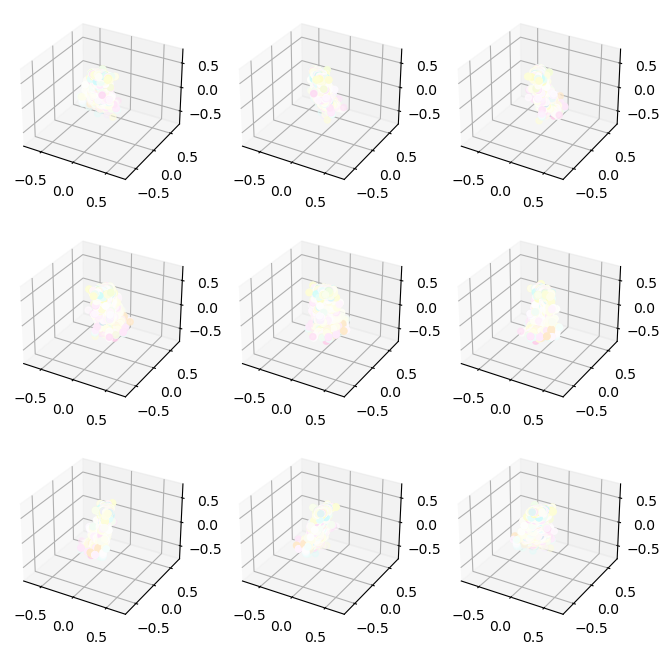

In [26]:

# ------------------------------------------------------------------------------
# 5) 采样
# ------------------------------------------------------------------------------
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R','G','B'],
    guidance_scale=[3.0, 0.0],               # 第二阶段 CFG 设 0 省显存
    model_kwargs_key_filter=["images,texts", "low res"]
)

##single:
# sampler = PointCloudSampler(
#     device=device,
#     models=[base_model],
#     diffusions=[base_diffusion],
#     num_points=[1024],
#     aux_channels=['R', 'G', 'B'],
#     model_kwargs_key_filter=["images,texts"], # Length 1
#     guidance_scale=[3.0],                   # Length 1
#     clip_denoised=True,                   
#     use_karras=[True],                      # Length 1
#     karras_steps=[64],                      # Length 1
#     sigma_min=[1e-3],                       # Length 1
#     sigma_max=[120],                        # Length 1 (default for base model is 120, upsampler is 160)
#     s_churn=[3.0]                          
# )

img = Image.open("example_data/light.png").convert("RGB")
samples = None
for s in tqdm(sampler.sample_batch_progressive(
        batch_size=1,
        model_kwargs={"images":[img], "texts":["white light"]})
    ):
    samples = s
#A sleek and modern two-tier ottoman featuring a plush, cushioned top in a light gray fabric. The base is composed of simple, slender metal legs, providing both stability and an elegant contrast to the soft upper layers. The design emphasizes clean lines and minimalism, making it a versatile addition to contemporary interiors.
    
#A sleek, modern dining chair featuring a plush, upholstered seat and backrest with rounded edges. The chair is predominantly white, complemented by a minimalist metal frame with clean lines, creating a contemporary aesthetic. The sturdy base provides stability and adds a subtle elegance to the overall design.
pc = sampler.output_to_point_clouds(samples)[0]
from point_e.util.plotting import plot_point_cloud

fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))


In [57]:
np.savez('light2.npz', coords=pc.coords, **pc.channels)

In [18]:
np.savez('whitepillow.npz', coords=pc.coords, **pc.channels)

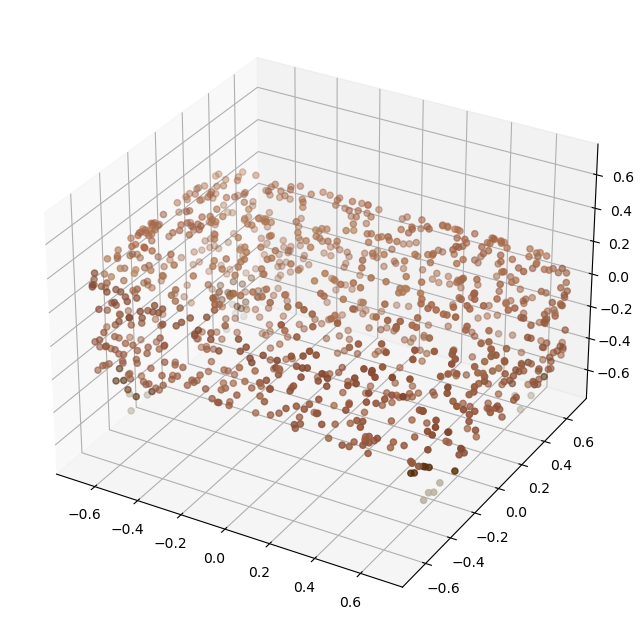

In [44]:
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

pc_raw = dataset[666]['pointcloud'] 
rgb = pc_raw[3:]          


plot_point_cloud(
    PointCloud(
        coords = pc_raw[:3].T,
        channels = {
            "R": rgb[0],     
            "G": rgb[1],
            "B": rgb[2],
        }
    )
).show()


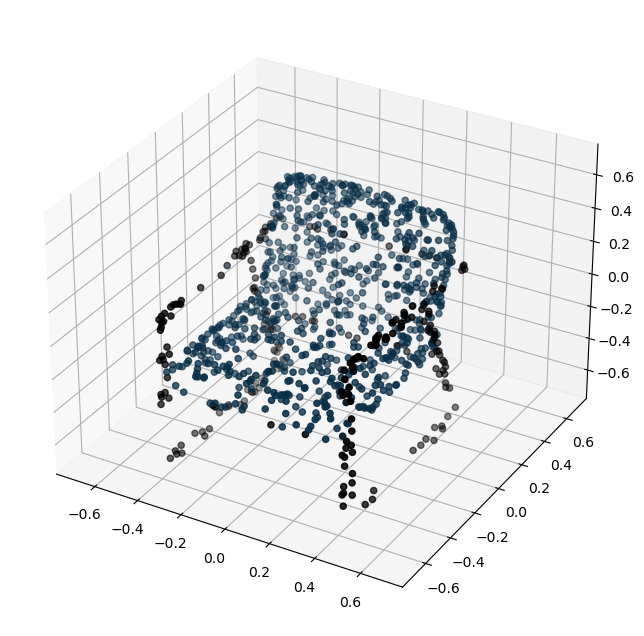

In [26]:
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

pc_raw = dataset[6]['pointcloud'] 
rgb = pc_raw[3:]          


plot_point_cloud(
    PointCloud(
        coords = pc_raw[:3].T,
        channels = {
            "R": rgb[0],     
            "G": rgb[1],
            "B": rgb[2],
        }
    )
).show()


# sample

In [8]:
print("base_diffusion var_type:", base_diffusion.model_var_type)          # fixed_large
print("base out_ch:", base_model.output_proj.out_features)                # 6
print("upsampler var_type:", upsampler_diffusion.model_var_type)          # fixed_small
print("upsampler out_ch:", upsampler_model.output_proj.out_features)      # 12

base_diffusion var_type: learned_range
base out_ch: 6
upsampler var_type: learned_range
upsampler out_ch: 12
